In [13]:
# Library Installation
!pip install yfinance numpy pandas datetime scikit-learn matplotlib.pyplot fredapi scipy

ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot


In [1]:
# Initialize
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import timedelta, datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from fredapi import Fred
from scipy.optimize import minimize

In [47]:
# CAPM regression for expected returns


# Preparation
def leap(x):
    n = 0
    year = end_date.year
    print(year)
    for i in range(x):
        if (year - i) % 4 == 0 and (year - i) % 100 != 0:
            n += 1
        if (year - i) % 100 == 0 and (year - i) % 400 == 0:
            n += 1
    return (x*365)+n

end_date = datetime.today() - timedelta(1)           
start_date = end_date - timedelta(leap(5))

stock_symbols = ["AAPL", "MSFT","GOOG", "AMZN", "NVDA", "META", "BRK-B", "TSLA", "LLY", "V"] #"META", "BRK-B", "TSLA", "LLY", "V"
market_index = '^GSPC' #'DJI'
num_assets = len(stock_symbols)

data = yf.download(stock_symbols, start = "2013-01-01", end = "2023-01-01")
market_data = yf.download(market_index, start = "2013-01-01", end = "2023-01-01")
adj_data = pd.DataFrame()
adj_market_data = pd.DataFrame()
adj_data = data['Adj Close']
adj_market_data = market_data['Adj Close']
#print(adj_data)


log_returns = np.log(adj_data / adj_data.shift(1)).dropna()
log_market_returns = np.log(adj_market_data / adj_market_data.shift(1)).dropna()
#print(log_returns)
#print(log_market_returns)


# Regression 
rmodel = LinearRegression()
x = log_market_returns.values.reshape(-1, 1)
y = log_returns.values
rmodel.fit(x,y)

stock_beta = rmodel.coef_ # b0 = beta of 1st stock, b1 = beta of 2nd stock, etc.
line = rmodel.intercept_
for i in range(num_assets):
    print(f"Beta for {stock_symbols[i]}: {stock_beta[i]}")
print()

# Preparing for calculating expected returns
fred = Fred(api_key='5f30d0ab3a11902af2b14f844a70e40f')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print('Risk Free Rate:','{:.5f}'.format(risk_free_rate))

# Calculating expected return for each asset
#print(log_market_returns.sum()) Cumulative returns

expected_market_return = log_market_returns.mean()*252 # log_market_returns is daily expected market return, *252 for annual
print('Expected Annual Market Return:', '{:.5f}'.format(expected_market_return))
expected_return = risk_free_rate + stock_beta * (expected_market_return - risk_free_rate)

np.set_printoptions(precision = 5, floatmode='fixed') # to ourput 5 decimal places

for i in range(num_assets):
    print(f"Expected Annual Return for {stock_symbols[i]}: {expected_return[i]}")


2023
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  1 of 1 completed
Beta for AAPL: [1.16910]
Beta for MSFT: [1.12444]
Beta for GOOG: [0.89385]
Beta for AMZN: [1.12286]
Beta for NVDA: [0.70263]
Beta for META: [1.24157]
Beta for BRK-B: [1.19227]
Beta for TSLA: [1.61931]
Beta for LLY: [1.42335]
Beta for V: [1.09735]

Risk Free Rate: 0.04800
Expected Annual Market Return: 0.09664
Expected Annual Return for AAPL: [0.10486]
Expected Annual Return for MSFT: [0.10269]
Expected Annual Return for GOOG: [0.09148]
Expected Annual Return for AMZN: [0.10262]
Expected Annual Return for NVDA: [0.08218]
Expected Annual Return for META: [0.10839]
Expected Annual Return for BRK-B: [0.10599]
Expected Annual Return for TSLA: [0.12676]
Expected Annual Return for LLY: [0.11723]
Expected Annual Return for V: [0.10138]


In [48]:
# Model evaluation
y_pred = rmodel.predict(x)

R2 = np.array([])
MAPE = np.array([])
for i in range(num_assets):
    R2 = np.append(R2, r2_score(y[:,i], y_pred[:,i]))
    MAPE = np.append(MAPE, mean_absolute_percentage_error(y[:,i], y_pred[:,i]))
for i in range(num_assets):
    print('R2', stock_symbols[i]+':', "{:.4f}".format(R2[i]))
    print('MAPE', stock_symbols[i]+':', str("{:.4f}".format(MAPE[i]*100)) + '%\n')

R2 AAPL: 0.5023
MAPE AAPL: 3504275392022.8027%

R2 MSFT: 0.3716
MAPE MSFT: 1218685676078.0588%

R2 GOOG: 0.6671
MAPE GOOG: 5700392829921.2236%

R2 AMZN: 0.5383
MAPE AMZN: 219.6374%

R2 NVDA: 0.2356
MAPE NVDA: 7990682446983.5430%

R2 META: 0.3253
MAPE META: 6083251042252.9668%

R2 BRK-B: 0.6052
MAPE BRK-B: 11076517015629.0215%

R2 TSLA: 0.4205
MAPE TSLA: 18537937118645.3906%

R2 LLY: 0.1947
MAPE LLY: 1629434595275.3972%

R2 V: 0.5930
MAPE V: 5304566139550.3340%



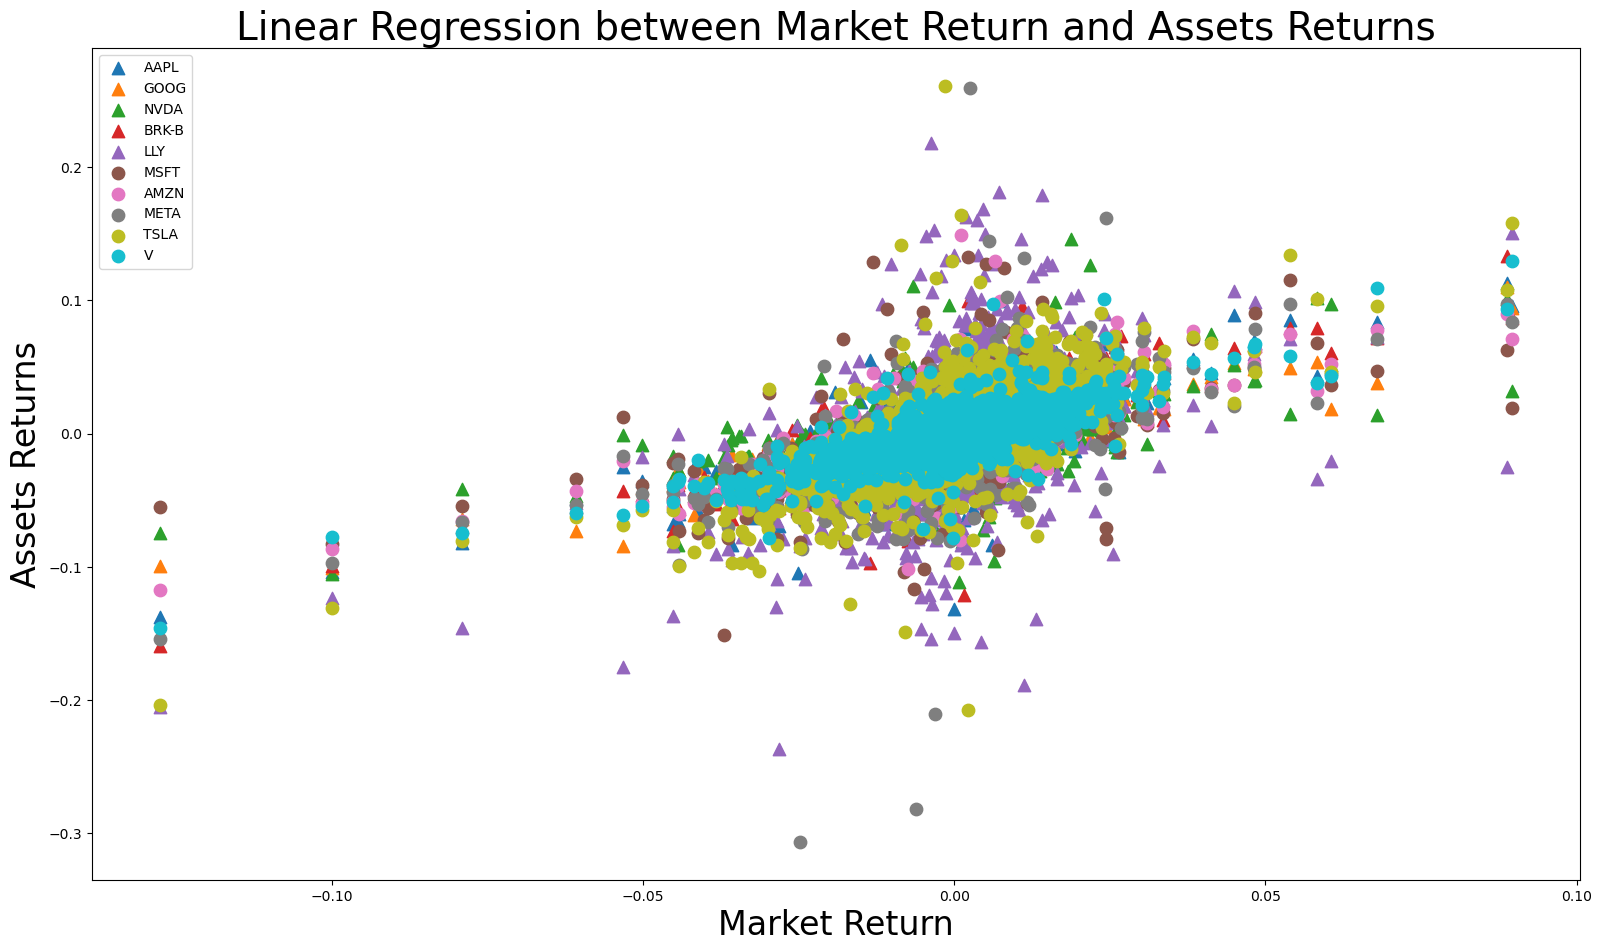

In [49]:
# Scatter plot shows relationship between assets returns and market return
plt.figure(figsize=(19.2,10.8))
for i in range(0, num_assets, 2):
    plt.scatter(x, y[:,i],s=80,  marker='^', label=stock_symbols[i])
for i in range(1, num_assets, 2):
    plt.scatter(x, y[:,i],s=80, marker='o', label=stock_symbols[i])    
plt.xlabel('Market Return', fontsize=24)
plt.ylabel('Assets Returns', fontsize=24)
plt.title('Linear Regression between Market Return and Assets Returns', fontsize = 28)
plt.legend()
plt.show()

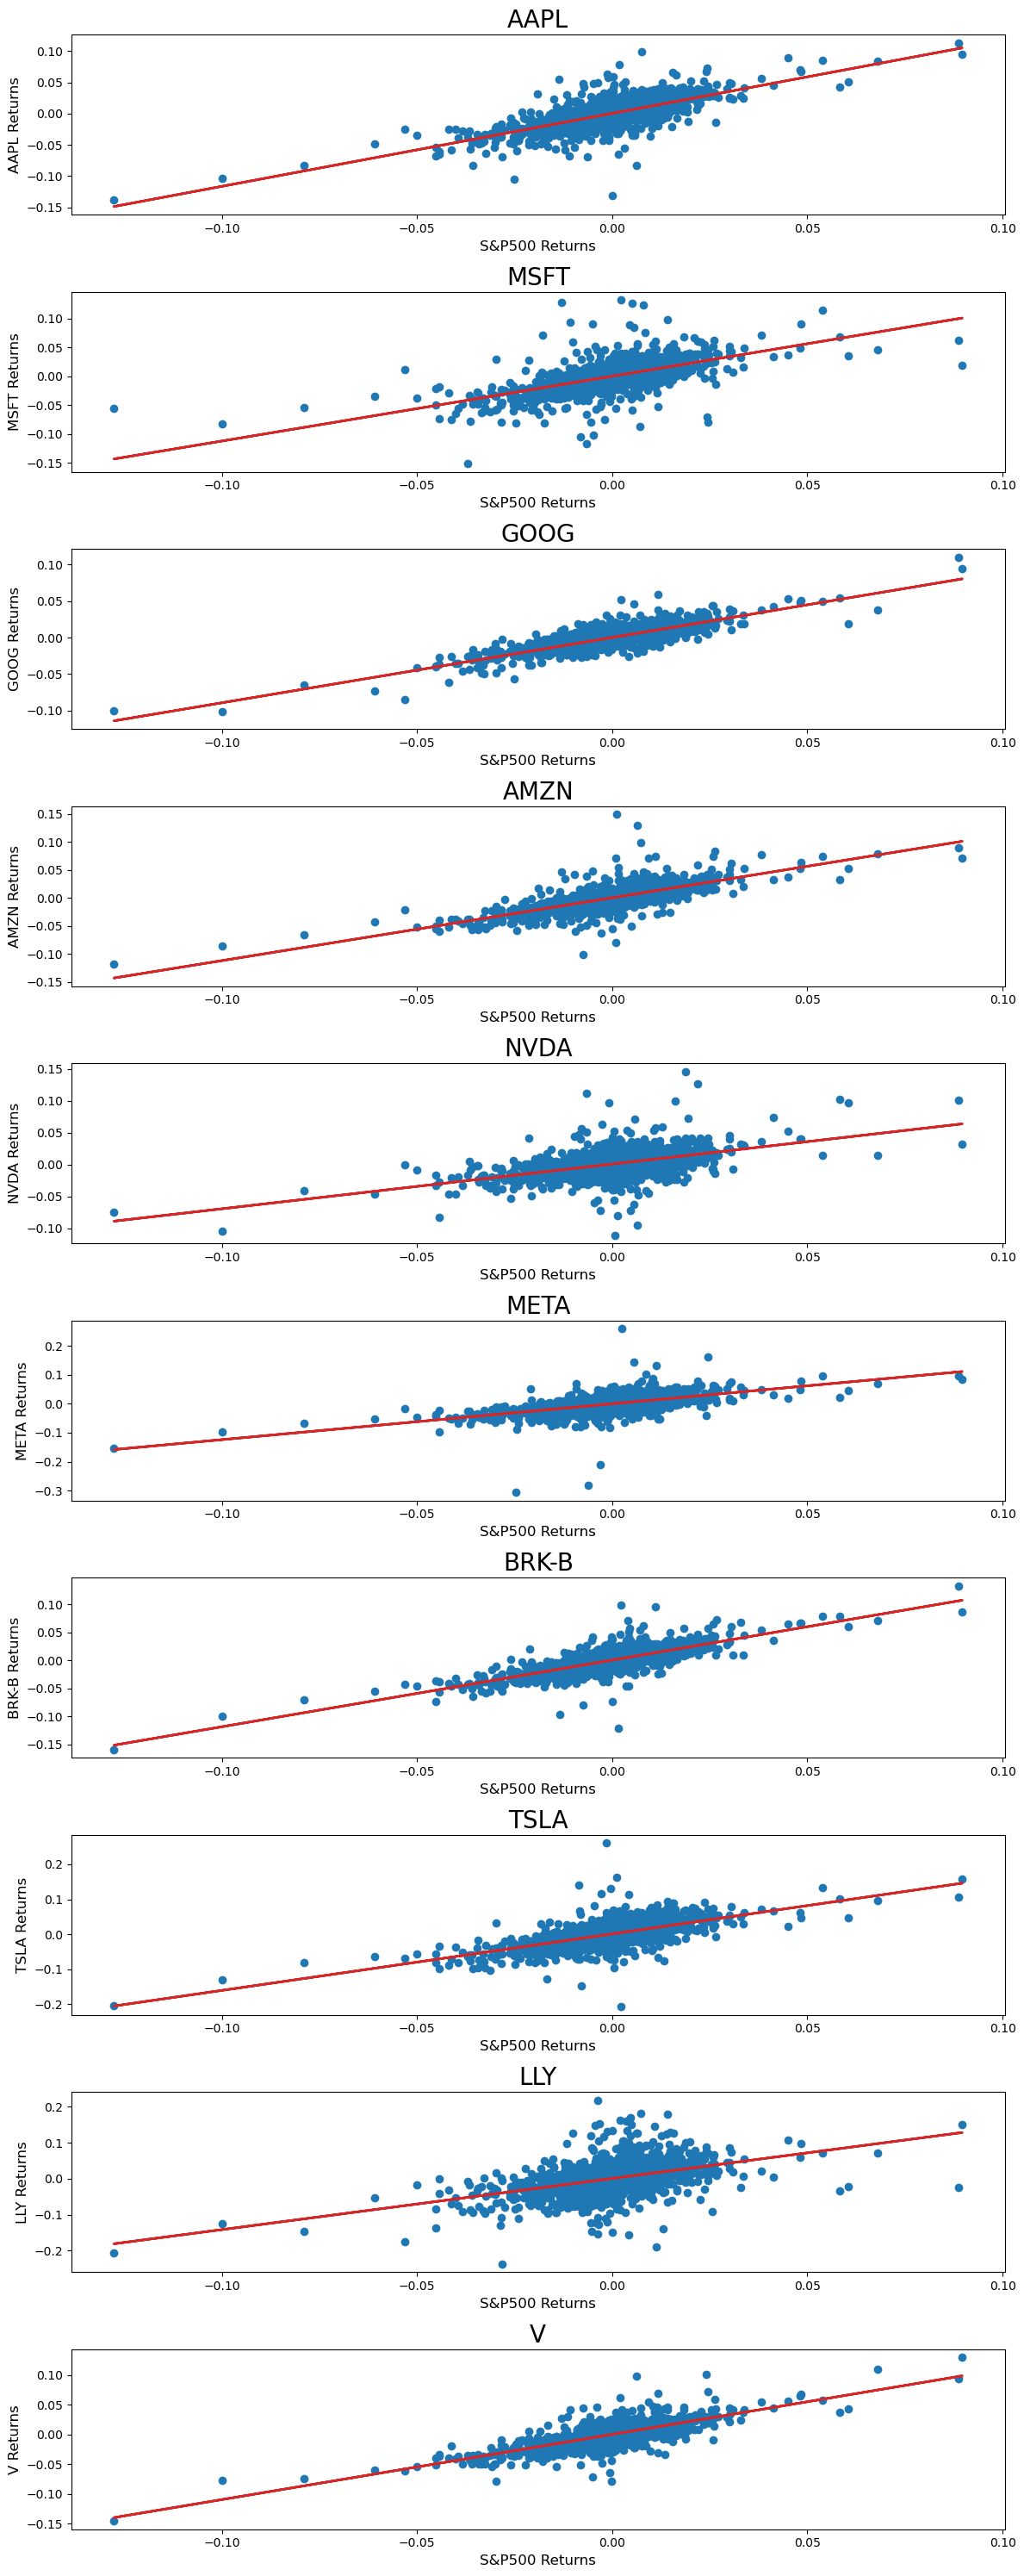

In [50]:
# Visualize regression results of each asset
num_rows = int(np.ceil(np.sqrt(num_assets)))
num_cols = int(np.ceil(num_assets / num_rows))
fig, axes = plt.subplots(num_assets, 1, figsize=(12,30))

axes = axes.flatten() # flatten the axes array if it's not 2D

for i, var in enumerate(stock_symbols):
    lin = line[i] 
    axes[i].scatter(x, y[:,i], color='tab:blue')
    axes[i].plot(x, stock_beta[i]*x+lin, linewidth=2, color='tab:red')
    axes[i].set_title(var, fontsize = 20)
    axes[i].set_ylabel(str(var) + ' Returns', fontsize = 12)
    axes[i].set_xlabel('S&P500 Returns', fontsize = 12)
    
plt.tight_layout()
plt.show()
                 

Optimal Weights: 
AAPL: 0.0501
MSFT: 0.0619
GOOG: 0.5000
AMZN: 0.0581
NVDA: 0.2661
META: 0.0000
BRK-B: 0.0000
TSLA: 0.0000
LLY: 0.0000
V: 0.0637

Expected Annual Return: 1.0436
Expected Volatility: 0.1768
Sharpe Ratio: 5.6307


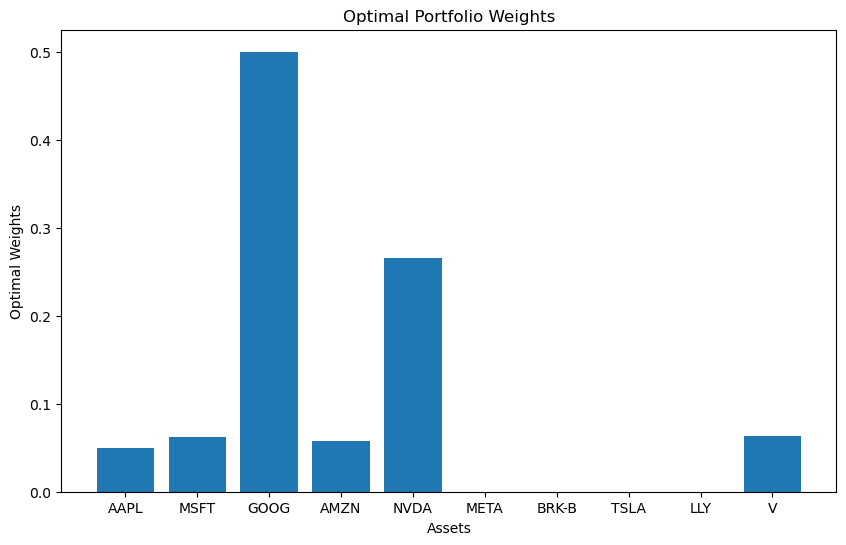

In [51]:
# Optimization
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights # @ is array multiplication
    return np.sqrt(variance)

def ann_expected_return(weights, log_returns): # key assumption: expected returns are based on historical returns
    return np.sum(expected_return*weights)

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (ann_expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)


cov_matrix = log_returns.cov() * 252 # annualize daily returns. 252 because it is a default assumption for number of trading days in a year
#print(cov_matrix)
constraints = {'type': 'eq', 'fun':lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(num_assets)]
initial_weights = np.array([1/num_assets]*num_assets)
#print(initial_weights)

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints = constraints, bounds=bounds)
optimal_weights = optimized_results.x

print('Optimal Weights: ')
for ticker, weight in zip(stock_symbols, optimal_weights):
    print(f"{ticker}: {weight:.4f}")
print()


optimal_portfolio_return = ann_expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")


# Visualize portfolio weights in bar chart
plt.figure(figsize = (10,6))
plt.bar(stock_symbols, optimal_weights)
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')
plt.show()